In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [6]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

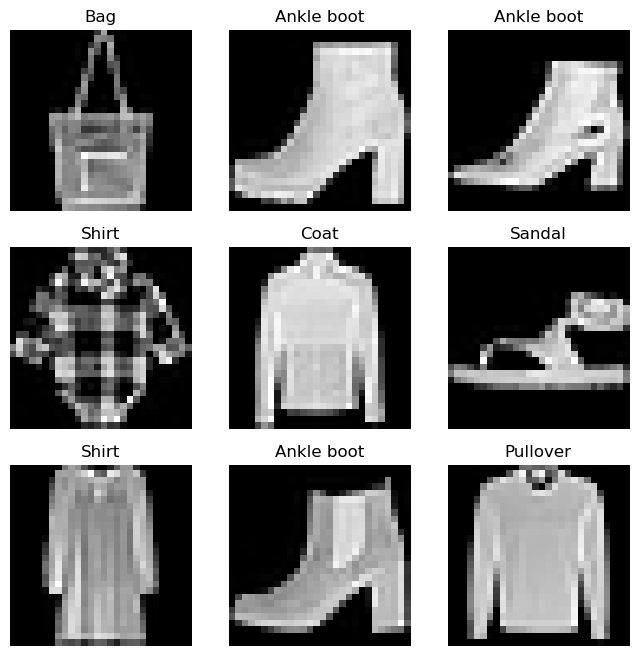

In [16]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298371  [   64/60000]
loss: 2.293272  [ 6464/60000]
loss: 2.274419  [12864/60000]
loss: 2.282115  [19264/60000]
loss: 2.261711  [25664/60000]
loss: 2.238578  [32064/60000]
loss: 2.237962  [38464/60000]
loss: 2.205104  [44864/60000]
loss: 2.205189  [51264/60000]
loss: 2.190003  [57664/60000]
Test Error: 
 Accuracy: 45.3%, Avg loss: 2.174639 

Epoch 2
-------------------------------
loss: 2.170557  [   64/60000]
loss: 2.169583  [ 6464/60000]
loss: 2.113304  [12864/60000]
loss: 2.141275  [19264/60000]
loss: 2.098986  [25664/60000]
loss: 2.041466  [32064/60000]
loss: 2.067376  [38464/60000]
loss: 1.987011  [44864/60000]
loss: 1.989490  [51264/60000]
loss: 1.954246  [57664/60000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.930608 

Epoch 3
-------------------------------
loss: 1.947277  [   64/60000]
loss: 1.930429  [ 6464/60000]
loss: 1.808550  [12864/60000]
loss: 1.860566  [19264/60000]
loss: 1.764485  [25664/60000]
loss: 1.703749  [32064/600

In [11]:
torch.save(model.state_dict(), "../models/fashion-mnist.pth")
print("Saved PyTorch Model State to ../models/fashion-mnist.pth")

Saved PyTorch Model State to ../models/fashion-mnist.pth


In [4]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("../models/fashion-mnist.pth"))

<All keys matched successfully>

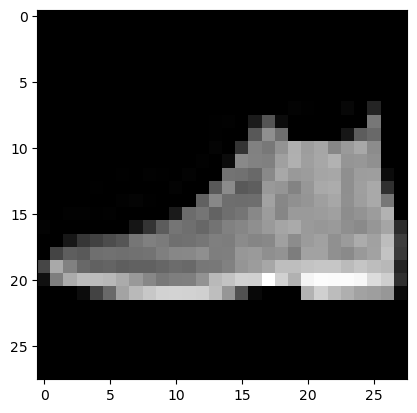

Predicted: "Ankle boot", Actual: "Ankle boot"


In [7]:
model.eval()
x, y = test_data[0][0], test_data[0][1]

plt.imshow(x.squeeze(), cmap="gray")
plt.show()

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [8]:
print(f"Shape of input image: {x.shape}")
print(f"Input image center: {x[:,12:16,12:16]}")

Shape of input image: torch.Size([1, 28, 28])
Input image center: tensor([[[0.0000, 0.0000, 0.4510, 0.4471],
         [0.0000, 0.3490, 0.5451, 0.3529],
         [0.3843, 0.5333, 0.4314, 0.4275],
         [0.4588, 0.3882, 0.4353, 0.4588]]], device='cuda:0')


In [9]:
flat_image = model.flatten(x)
flat_image_center = torch.stack((
    flat_image[:,348:352][0],
    flat_image[:,376:380][0],
    flat_image[:,404:408][0],
    flat_image[:,432:436][0]))
print(f"Shape of flat image: {flat_image.shape}")
print(f"Flat image center: {flat_image_center}")

Shape of flat image: torch.Size([1, 784])
Flat image center: tensor([[0.0000, 0.0000, 0.4510, 0.4471],
        [0.0000, 0.3490, 0.5451, 0.3529],
        [0.3843, 0.5333, 0.4314, 0.4275],
        [0.4588, 0.3882, 0.4353, 0.4588]], device='cuda:0')


In [16]:
layer1_weight = model.get_parameter("linear_relu_stack.0.weight")
layer1_bias = model.get_parameter("linear_relu_stack.0.bias")

print(f"layer 1 weight - Shape: {layer1_weight.shape} - Values: {layer1_weight}")
print(f"layer 1 bias - Shape: {layer1_bias.shape} - Values: {layer1_bias}")

layer 1 weight - Shape: torch.Size([512, 784]) - Values: Parameter containing:
tensor([[ 0.0166, -0.0215, -0.0213,  ...,  0.0249, -0.0333,  0.0195],
        [ 0.0019,  0.0064, -0.0097,  ..., -0.0314,  0.0137, -0.0085],
        [-0.0215, -0.0111, -0.0079,  ...,  0.0136, -0.0033,  0.0346],
        ...,
        [ 0.0033,  0.0057, -0.0331,  ...,  0.0188,  0.0275, -0.0074],
        [-0.0124, -0.0270, -0.0229,  ..., -0.0219, -0.0196, -0.0023],
        [-0.0082,  0.0086,  0.0155,  ...,  0.0073, -0.0347, -0.0143]],
       device='cuda:0', requires_grad=True)
layer 1 bias - Shape: torch.Size([512]) - Values: Parameter containing:
tensor([ 2.6567e-02,  6.3177e-03,  6.0578e-03,  3.2456e-03,  4.2460e-02,
         2.5497e-03, -7.8638e-03, -1.1674e-03,  2.7715e-02,  1.0238e-02,
        -2.8850e-02,  2.2727e-02,  8.7578e-03, -1.7382e-02,  2.3547e-02,
        -1.5281e-02,  2.9908e-02,  8.9176e-03, -5.5175e-03,  2.0215e-02,
         1.0769e-02,  2.2023e-02,  3.1302e-02, -1.2984e-02, -1.3096e-02,
      

In [17]:
layer1 = model.linear_relu_stack[0]
hidden1 = layer1(flat_image)

print(f"Shape of hidden 1: {hidden1.shape}")
print(f"Hidden 1: {hidden1}")

Shape of hidden 1: torch.Size([1, 512])
Hidden 1: tensor([[ 4.7023e-01,  5.3192e-01,  3.9917e-02,  6.2203e-01,  5.4609e-01,
          7.7525e-02,  3.9193e-01,  4.3129e-01,  2.1754e-01, -1.0306e-02,
         -9.5101e-02,  3.7093e-01,  2.0274e-01,  9.1209e-01, -3.1995e-01,
          1.3447e-01,  2.9983e-01,  3.3304e-01,  1.6213e-01,  1.7942e-01,
         -2.0478e-01, -7.1918e-02,  1.7913e-01,  3.6763e-01, -1.7919e-02,
          1.1502e+00,  7.4470e-01,  1.0965e-01,  3.4227e-02,  1.4799e-01,
          3.1840e-01, -1.1400e-01, -3.8621e-03, -1.6962e-03,  3.1034e-01,
         -1.9679e-01,  5.1626e-02, -1.6058e-01,  2.2335e-01,  3.8226e-01,
          3.6692e-01, -7.9282e-02, -2.1028e-01, -1.0165e-01, -8.0525e-02,
          3.6647e-01, -1.9063e-01, -4.1263e-04,  2.6500e-01,  3.2607e-02,
         -1.8676e-01,  3.1039e-01,  5.7008e-01,  6.8967e-01, -5.1019e-02,
         -1.4922e-01, -7.0927e-02,  5.9328e-02, -1.9945e-01,  7.5197e-01,
          3.4744e-01,  8.5129e-02, -3.0855e-01, -3.8942e-01, -